<a href="https://colab.research.google.com/github/gongx030/seatac_manuscript/blob/main/GM12878_SeATAC_MACS2_compare_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Compare the differential V-plots calling by SeATAC and MACS2 on synthetic GM12878 ATAC-seq data


SeATAC and MACS2 were used to call the differential V-plots on a synthetic dataset derived from the full GM12878 ATAC-seq data. 

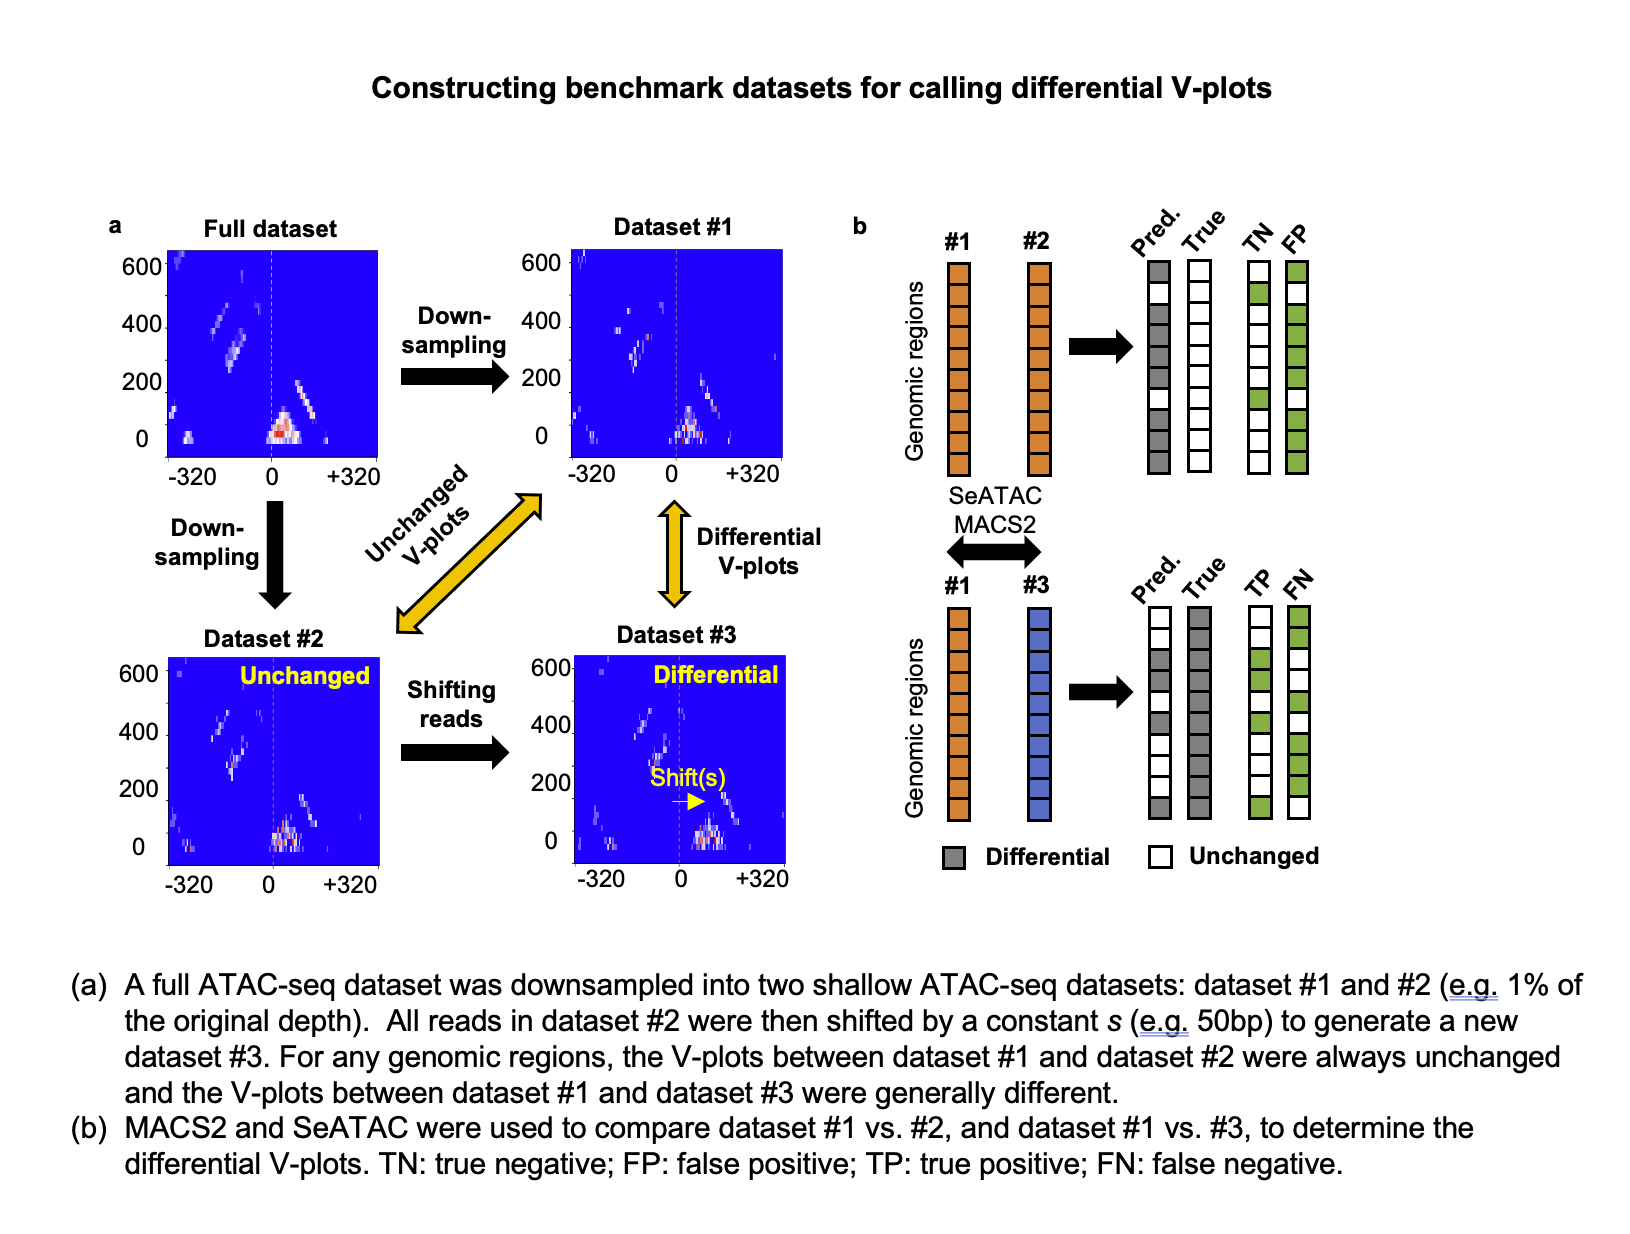

In [ ]:
start_time <- Sys.time()

### Install R packages from CRAN

In [ ]:
install.packages('BiocManager')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
required_packages <- c(
  "GenomicRanges",
  'ggplot2', 'patchwork',
  'BSgenome.Hsapiens.UCSC.hg19',
  'MatrixGenerics',
  'AUC'
 )

In [ ]:
missing_packages <- required_packages[!required_packages %in% rownames(installed.packages())]
if (length(missing_packages) > 0){
    BiocManager::install(missing_packages)
}

In [ ]:
library(devtools)

### Load R packages

In [ ]:
library(GenomicRanges)
library(dplyr)
library(ggplot2)
library(BSgenome.Hsapiens.UCSC.hg19)
library(MatrixGenerics)
library(AUC)
library(broom)
library(patchwork)

## Parameters

In [ ]:
ARGS <- list(
  block_size = 640L,
  remote_bam_file = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Buenrostro_version=20170721a/GM12878_50k_cells.bam',
  remote_bed_file = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Buenrostro_version=20170721a/GM12878_50k_cells_summits.bed',
  local_bam_file = './s3.msi.umn.edu/gongx030/datasets/dataset=Buenrostro_version=20170721a/GM12878_50k_cells.bam',
  local_bed_file = './s3.msi.umn.edu/gongx030/datasets/dataset=Buenrostro_version=20170721a/GM12878_50k_cells_summits.bed'
)


In [ ]:
config <- list(
  remote_bam_file = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Buenrostro_version=20170721a/GM12878_50k_cells.bam',
  remote_bed_file = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Buenrostro_version=20170721a/GM12878_50k_cells_summits.bed',
  seed1 = 1:3,
  seed2 = 1:3,
  pct = c(0.01, 0.1),
  genome = 'hg19',
  window_size = 1000L,
  step_size = 100L,
  bin_size = 5L,
  fragment_size_range_max = 640L,
  fragment_size_interval = 10L,
  block_size = 640L,
  min_reads_train = 10L,
  max_train_blocks = 5000L,
  vae_latent = 5L,
  vae_filters0 = c(128L),
  vae_filters = c(32L),
  vae_downsample_layers = 4L,
  vae_upsample_layers = 4L,
  vae_base_learning_rate = c(1e-2),
  vae_epochs = 200L,
  vae_beta_schedule_method = c('constant'),
  vae_beta0 = 1,
  vae_batch_size = c(128L),
  vae_warmup_ratio = 0.1,
  shift_size = c(10L, 20L, 50L, 100L)
) %>%
  expand.grid() %>%
  filter(seed1 != seed2) %>%
  mutate(local_bam_file = gsub('https://', './', remote_bam_file)) %>%
  mutate(local_bed_file = gsub('https://', './', remote_bed_file)) %>%
  mutate(remote_ds_bam_file1 = mapply(gsub, '.bam', sprintf('_seed=%d_pct=%.4f.bam', seed1, pct), remote_bam_file)) %>%
  mutate(remote_ds_negative_bam_file2 = mapply(gsub, '.bam', sprintf('_seed=%d_pct=%.4f.bam', seed2, pct), remote_bam_file)) %>%
  mutate(remote_ds_positive_bam_file2 = mapply(gsub, '.bam', sprintf('_seed=%d_pct=%.4f_shift=%d.bam', seed2, pct, shift_size), remote_bam_file)) %>%
  mutate(local_ds_bam_file1 = gsub('https://', './', remote_ds_bam_file1)) %>%
  mutate(local_ds_negative_bam_file2 = gsub('https://', './', remote_ds_negative_bam_file2)) %>%
  mutate(local_ds_positive_bam_file2 = gsub('https://', './', remote_ds_positive_bam_file2)) %>%
  
  mutate(remote_seatac_negative_output_file = mapply(gsub, '.bam', sprintf('/seed=%d_pct=%.4f/bin_size=%d_fragment_size_range_max=%d_fragment_size_interval=%d_block_size=%d/min_reads_train=%d_max_train_blocks=%d/vae_latent=%d_vae_filters0=%d_vae_filters=%d_vae_downsample_layers=%d_vae_upsample_layers=%d_vae_epochs=%d.tsv', seed2, pct, bin_size, fragment_size_range_max, fragment_size_interval, block_size, min_reads_train, max_train_blocks, vae_latent, vae_filters0, vae_filters, vae_downsample_layers, vae_upsample_layers, vae_epochs), remote_ds_bam_file1)) %>%
  mutate(remote_seatac_positive_output_file = mapply(gsub, '.bam', sprintf('/seed=%d_pct=%.4f_shift=%d/bin_size=%d_fragment_size_range_max=%d_fragment_size_interval=%d_block_size=%d/min_reads_train=%d_max_train_blocks=%d/vae_latent=%d_vae_filters0=%d_vae_filters=%d_vae_downsample_layers=%d_vae_upsample_layers=%d_vae_epochs=%d.tsv', seed2, pct, shift_size, bin_size, fragment_size_range_max, fragment_size_interval, block_size, min_reads_train, max_train_blocks, vae_latent, vae_filters0, vae_filters, vae_downsample_layers, vae_upsample_layers, vae_epochs), remote_ds_bam_file1))  %>%
  
  # Colab does not support very long filenames
  mutate(local_seatac_negative_output_file = mapply(gsub, '.bam', sprintf('/seed=%d_pct=%.4f/seatac.tsv', seed2, pct), local_ds_bam_file1)) %>%
  mutate(local_seatac_positive_output_file = mapply(gsub, '.bam', sprintf('/seed=%d_pct=%.4f_shift=%d/seatac.tsv', seed2, pct, shift_size), local_ds_bam_file1)) %>%

  mutate(remote_macs2_negative_output_file = mapply(gsub, '.bam', sprintf('/seed=%d_pct=%.4f_shift=%d/output.tsv', seed2, pct, shift_size), remote_ds_bam_file1)) %>%
  mutate(remote_macs2_positive_output_file = mapply(gsub, '.bam', sprintf('/seed=%d_pct=%.4f/output.tsv', seed2, pct), remote_ds_bam_file1)) %>%
  mutate(local_macs2_negative_output_file = gsub('https://', './', remote_macs2_negative_output_file)) %>% 
  mutate(local_macs2_positive_output_file = gsub('https://', './', remote_macs2_positive_output_file)) %>% 
 
  mutate(remote_ds_nucleoatac_bw_file1 = gsub('.bam', '.nucleoatac_signal.smooth.bw', remote_ds_bam_file1)) %>%
  mutate(remote_ds_negative_nucleoatac_bw_file2 = gsub('.bam', '.nucleoatac_signal.smooth.bw', remote_ds_negative_bam_file2)) %>%
  mutate(remote_ds_positive_nucleoatac_bw_file2 = remote_ds_negative_nucleoatac_bw_file2) %>% # we don't have a nucleoatac file for shifted BAMs
  mutate(local_ds_nucleoatac_bw_file1 = gsub('https://', './', remote_ds_nucleoatac_bw_file1)) %>%
  mutate(local_ds_negative_nucleoatac_bw_file2 = gsub('https://', './', remote_ds_negative_nucleoatac_bw_file2)) %>%
  mutate(local_ds_positive_nucleoatac_bw_file2 = gsub('https://', './', remote_ds_positive_nucleoatac_bw_file2)) 


In [ ]:
sprintf('# configs: %d', nrow(config)) %>% message()

# configs: 48



## Download SeATAC output 

In [ ]:
for (i in 1:nrow(config)){
  sprintf('wget -O %s %s', config[i, 'local_seatac_negative_output_file'], config[i, 'remote_seatac_negative_output_file']) %>% system()
}
all(file.exists(config[, 'local_seatac_negative_output_file']))

[1] TRUE

In [ ]:
for (i in 1:nrow(config)){
  sprintf('wget -O %s %s', config[i, 'local_seatac_positive_output_file'], config[i, 'remote_seatac_positive_output_file']) %>% system()
}
all(file.exists(config[, 'local_seatac_positive_output_file']))

[1] TRUE

## Download MACS2 output

In [ ]:
for (f in config$remote_macs2_negative_output_file){
  sprintf('wget -cx %s', f) %>% system()
}
all(file.exists(config$local_macs2_negative_output_file))

[1] TRUE

In [ ]:
for (f in config$remote_macs2_positive_output_file){
  sprintf('wget -cx %s', f) %>% system()
}
all(file.exists(config$local_macs2_positive_output_file))

[1] TRUE

## Download full GM12878 data

In [ ]:
sprintf('wget -cx %s', unique(config$remote_bed_file)) %>% system()

In [ ]:
#sprintf('wget -cx %s', unique(config$remote_bam_file)) %>% system()

In [ ]:
gr <- read.table(ARGS[['local_bed_file']], header = FALSE, sep = '\t')
gr <- GRanges(seqnames = gr[, 1], range = IRanges(start = gr[, 2], end = gr[, 3])) %>%
    resize(fix = 'center', width = ARGS[['block_size']])

## Download the NucleoATAC results from downsampled data

In [ ]:
for (f in unique(config$remote_ds_nucleoatac_bw_file1)){
  sprintf('wget -cx %s', f) %>% system()
}
all(file.exists(config$local_ds_nucleoatac_bw_file1))
all(file.exists(config$local_ds_negative_nucleoatac_bw_file2))
all(file.exists(config$local_ds_positive_nucleoatac_bw_file2))

[1] TRUE

[1] TRUE

[1] TRUE

## Compute the NucleoATAC results

In [ ]:
res <- list()
res[['nucleoatac']] <- NULL

In [ ]:
for (i in 1:nrow(config)){
  sprintf('%d/%d', i, nrow(config)) %>% message()
  gr_shifted <- shift(gr, config[i, 'shift_size'])
  cvg1 <- rtracklayer::import(config[i, 'local_ds_nucleoatac_bw_file1'], which = gr, as = 'Rle')
  cvg2_positive <- rtracklayer::import(config[i, 'local_ds_positive_nucleoatac_bw_file2'], which = gr_shifted , as = 'Rle')
  cvg2_negative <- rtracklayer::import(config[i, 'local_ds_negative_nucleoatac_bw_file2'], which = gr, as = 'Rle')
  m1 <- cvg1[gr] %>% as.matrix()
  m2_negative <- cvg2_negative[gr] %>% as.matrix()
  m2_positive <- cvg2_positive[gr_shifted] %>% as.matrix()  
  dp <- rowMaxs(abs(m1 - m2_positive))
  dn <- rowMaxs(abs(m1 - m2_negative))
  res[['nucleoatac']] <- cbind(res[['nucleoatac']], c(dp, dn))
}

1/48

2/48

3/48

4/48

5/48

6/48

7/48

8/48

9/48

10/48

11/48

12/48

13/48

14/48

15/48

16/48

17/48

18/48

19/48

20/48

21/48

22/48

23/48

24/48

25/48

26/48

27/48

28/48

29/48

30/48

31/48

32/48

33/48

34/48

35/48

36/48

37/48

38/48

39/48

40/48

41/48

42/48

43/48

44/48

45/48

46/48

47/48

48/48



## Read SeATAC and MACS2 results

In [ ]:
res[['seatac']] <- rbind(
  do.call('cbind', lapply(1:nrow(config), function(i) read.table(config[i, 'local_seatac_positive_output_file'], header = FALSE, sep = '\t')[, 5])),
  do.call('cbind', lapply(1:nrow(config), function(i) read.table(config[i, 'local_seatac_negative_output_file'], header = FALSE, sep = '\t')[, 5]))
)

In [ ]:
res[['macs']] <- rbind(
  do.call('cbind', lapply(1:nrow(config), function(i) read.table(config[i, 'local_macs2_positive_output_file'], header = FALSE, sep = '\t')[, 5])),
  do.call('cbind', lapply(1:nrow(config), function(i) read.table(config[i, 'local_macs2_negative_output_file'], header = FALSE, sep = '\t')[, 5]))
)

## Compute ROC

In [ ]:
params <- expand.grid(
  shift_size = c(10L, 20L, 50L, 100L),
  vae_latent = c(5L),
  pct = c(0.01, 0.1)
)
y <- rep(c(TRUE, FALSE), each = length(gr)) %>% factor()
auc <- list()
roc <- NULL

In [ ]:
for (i in 1:nrow(params)){
  g <- config$shift_size == params[i, 'shift_size'] & config$vae_latent == params[i, 'vae_latent'] & config$pct == params[i, 'pct']
  if (any(g)){
    auc[[i]] <- list()
    for (method in c('seatac', 'macs', 'nucleoatac')){
      y_pred <- rowMeans(res[[method]][, g, drop = FALSE], na.rm = TRUE)
      r <- roc(y_pred, y)
      roc <- rbind(roc, cbind(params[i, ], data.frame(method = method, tidy(r))))
      auc[[i]][[method]] <- auc(r)
    }
  }
}

Warning message in data.frame(..., check.names = FALSE):
“row names were found from a short variable and have been discarded”
Warning message in data.frame(..., check.names = FALSE):
“row names were found from a short variable and have been discarded”
Warning message in data.frame(..., check.names = FALSE):
“row names were found from a short variable and have been discarded”
Warning message in data.frame(..., check.names = FALSE):
“row names were found from a short variable and have been discarded”
Warning message in data.frame(..., check.names = FALSE):
“row names were found from a short variable and have been discarded”
Warning message in data.frame(..., check.names = FALSE):
“row names were found from a short variable and have been discarded”
Warning message in data.frame(..., check.names = FALSE):
“row names were found from a short variable and have been discarded”
Warning message in data.frame(..., check.names = FALSE):
“row names were found from a short variable and have been dis

In [ ]:
cbind(params, do.call('rbind', lapply(auc, as.data.frame)))

shift_size,vae_latent,pct,seatac,macs,nucleoatac
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
10,5,0.01,0.5525024,0.4985278,0.5008314
20,5,0.01,0.5615428,0.4979474,0.5017195
50,5,0.01,0.5635105,0.4968871,0.5036847
100,5,0.01,0.6309653,0.4954758,0.5053957
10,5,0.10,0.6485379,0.4672095,0.5040851
20,5,0.10,0.6722191,0.4655122,0.5125924
50,5,0.10,0.7078268,0.4589507,0.5355379
100,5,0.10,0.7952176,0.4506367,0.5436532


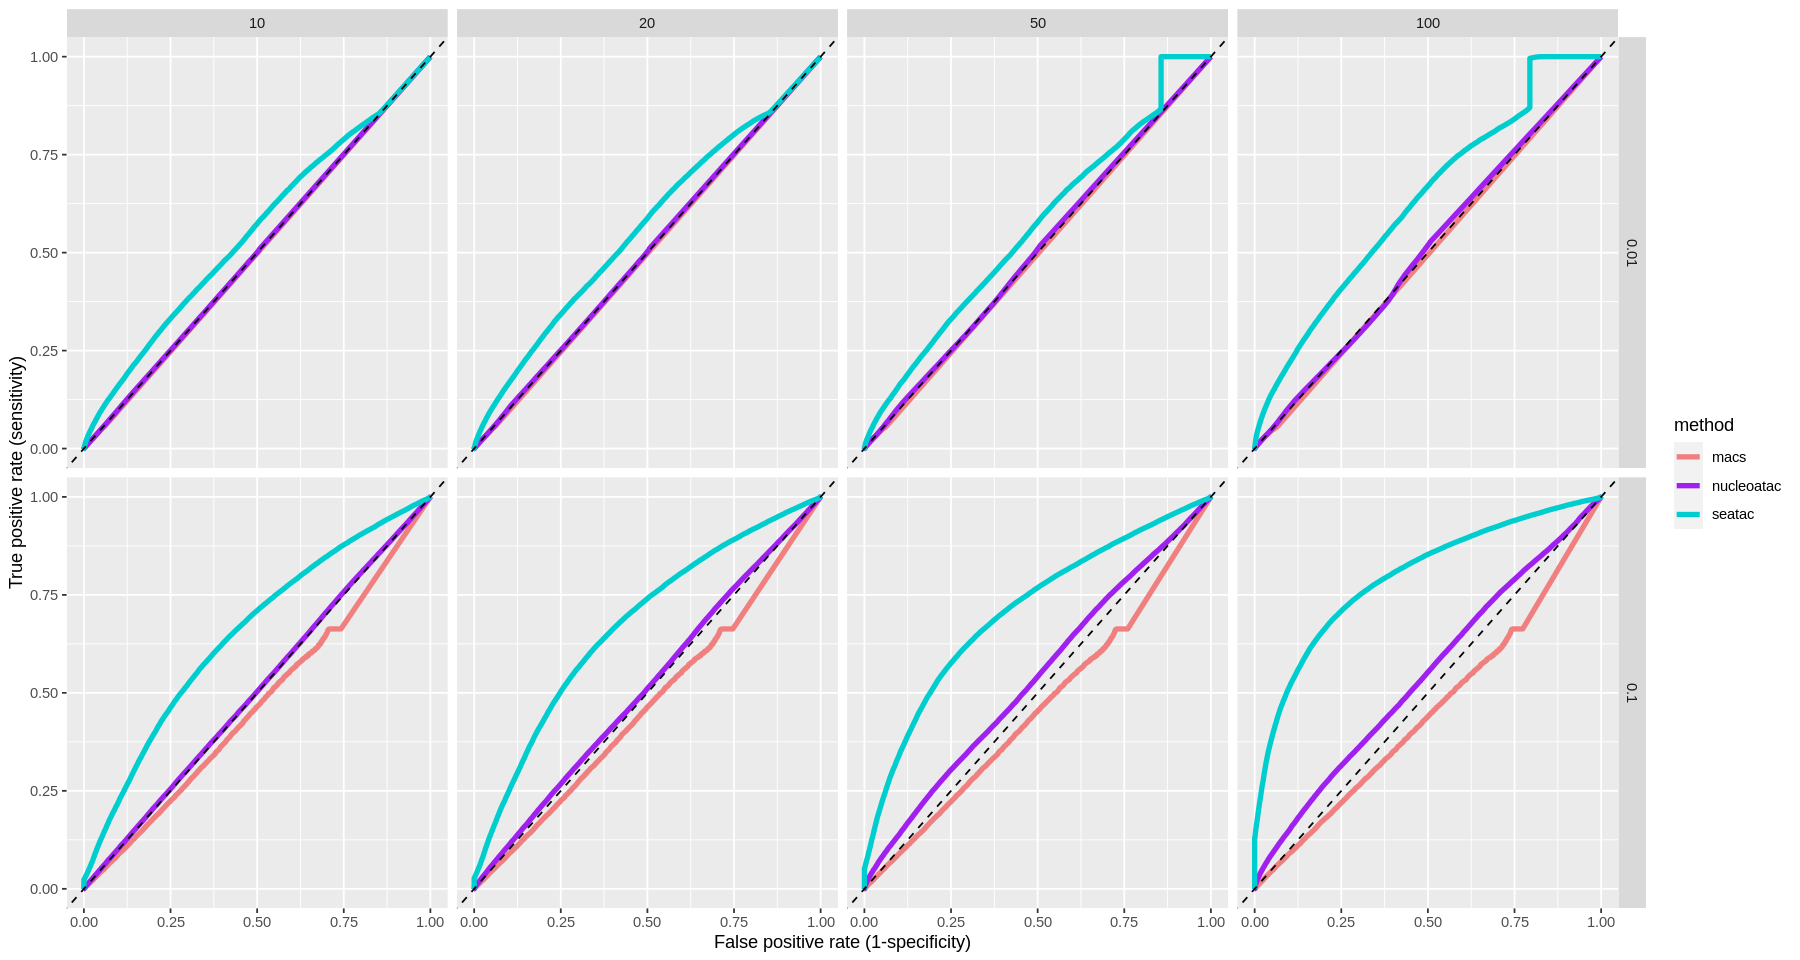

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 8)
roc %>% 
  ggplot(aes( x= fpr, y = tpr, color = method)) +
  geom_line(size = 1.5) +
  xlab("False positive rate (1-specificity)") + 
  ylab("True positive rate (sensitivity)") +
  facet_grid(pct ~ shift_size) + 
  geom_abline(intercept = 0, slope = 1, linetype = 'dashed') + 
  scale_color_manual(values= c(macs = 'lightcoral', nucleoatac = 'purple', seatac = 'cyan3')) +
  scale_fill_manual(values= c(macs = 'lightcoral', nucleoatac = 'purple', seatac = 'cyan3'))

## SessionInfo

In [ ]:
sessionInfo()

R version 4.1.2 (2021-11-01)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] patchwork_1.1.1                   broom_0.7.12                     
 [3] AUC_0.3.0                         MatrixGenerics_1.6.0             
 [5] matrixStats_0.61.0                BSgenome.Hsapiens.UCSC.hg19_1.4.3
 [7] BSgenome_1.62.0                 

In [ ]:
Sys.time() - start_time

Time difference of 2.536077 mins